In [1]:
import numpy as np
import matplotlib as plt
import seaborn as sb
import pandas as pd
import datetime as dtt
from sklearn.linear_model import LinearRegression as LR

In [17]:
working['BEGIN_DATE_STR'] = working.apply(lambda r : str(r.BEGIN_YEARMONTH) + str(r.BEGIN_DAY),axis=1)
working['BEGIN_DATE'] = pd.to_datetime(working['BEGIN_DATE_STR'],format='%Y%m%d')
supercluster = [pd.to_datetime(x,format='%Y%m%d') for x in ['20110425','20110426','20110427','20110428',]]
mask = ~working['BEGIN_DATE'].isin(supercluster)


In [18]:
working = pd.read_csv('../StormEvents_details_WORKING.csv')
working = working[mask]
#limit to the contigous US, https://en.wikipedia.org/wiki/List_of_extreme_points_of_the_United_States
#and https://geohack.toolforge.org for the decimal values
#Northern most Point of contigous US - Sumas, Washington 49°00′08.6″N 122°15′40″W 
#Southern most Point of contigous US - Western Dry Rocks, Florida Keys, Florida 24°26.8′N 81°55.6′W
#Eastern most point of mainland US - West Quoddy Head, Maine 44°48′55.4″N 66°56′59.2″W
#Western most point of mainland US - Cape Alava, Washington 48°9′51″N 124°43′59″W 
N_cut = (49.002389, -122.261111)
S_cut = (24.446667, -81.926667)
E_cut = (44.815389, -66.949778)
W_cut = (48.164167, -124.733056)

map_cut1 = working[working['BEGIN_LAT'] <= N_cut[0]]
map_cut2 = map_cut1[map_cut1['BEGIN_LAT'] >= S_cut[0]]
map_cut3 = map_cut2[map_cut2['BEGIN_LON'] >= -110]#W_cut[1]]
usa = map_cut3[map_cut3['BEGIN_LON'] <= E_cut[1]]

map_cut1 = 0
map_cut2 = 0
map_cut3 = 0

#add explicit month and year columns
t0 = dtt.datetime(1950, 1, 1)
d = np.array(usa['BEGIN_YEARMONTH'].values, dtype = str)
yr = []
mo = []
time_axis = []
i = 0
while i < len(d):
    tem = d[i]
    #splite the year and month values for ease of use
    yr_tem = int(tem[:4])
    mo_tem = int(tem[4:])
    
    times = dtt.datetime(yr_tem, mo_tem, usa['BEGIN_DAY'].values[i])
    yr.append(yr_tem)
    mo.append(mo_tem)
    delta = times - t0
    time_axis.append(delta.days)
    i += 1

#add the columns
usa['BEGIN_YEAR'] = np.array(yr)
usa['BEGIN_MONTH'] = np.array(mo)

#train on everything up to 2010, test on the last decade
test_train_cut = 2020
usa_train = usa[usa['BEGIN_YEAR'] < test_train_cut]
usa_test = usa[usa['BEGIN_YEAR'] >= test_train_cut]

In [19]:
#takes different counts of tornadoes and deaths and averages of position
def mean_deaths_dec(data_passed, yr, N):
    data = data_passed[data_passed['BEGIN_YEAR'].between(yr, yr+N)]
    
    lons = data['BEGIN_LON'].values
    lats = data['BEGIN_LAT'].values
    deaths_d = data['DEATHS_DIRECT'].values
    deaths_i = data['DEATHS_INDIRECT'].values
    deaths = deaths_d + deaths_i

    injuries_d = data['INJURIES_DIRECT'].values
    injuries_i = data['INJURIES_INDIRECT'].values
    injuries = injuries_d + injuries_i

    #total deaths and injuries
    d_t = deaths.sum()
    inj_t = injuries.sum()

    #unweighted average position
    lons_m = np.average(lons)
    lats_m = np.average(lats)
    c_m = (lons_m, lats_m)
    
    #total tornadoes
    N_t = len(data['BEGIN_LON'].values)

    #need the last year's december to keep everything consistent in time
    pas_yr = data_passed[data_passed['BEGIN_YEAR'] == yr-1]
    dec = pas_yr[pas_yr['BEGIN_MONTH'] == 12]

    #splitting up into months
    jan = data[data['BEGIN_MONTH'] == 1]
    feb = data[data['BEGIN_MONTH'] == 2]
    mar = data[data['BEGIN_MONTH'] == 3]
    apr = data[data['BEGIN_MONTH'] == 4]
    may = data[data['BEGIN_MONTH'] == 5]
    jun = data[data['BEGIN_MONTH'] == 6]
    jul = data[data['BEGIN_MONTH'] == 7]
    aug = data[data['BEGIN_MONTH'] == 8]
    sep = data[data['BEGIN_MONTH'] == 9]
    oct = data[data['BEGIN_MONTH'] == 10]
    nov = data[data['BEGIN_MONTH'] == 11]

    #splitting up into seasons
    cut_1 = pd.concat((dec, jan, feb))
    cut_2 = pd.concat((mar, apr, may))
    cut_3 = pd.concat((jun, jul, aug))
    cut_4 = pd.concat((sep, aug, nov))

    #take averages for each season
    #dec-jan-feb
    lons_1 = cut_1['BEGIN_LON'].values
    lats_1 = cut_1['BEGIN_LAT'].values
    deaths_1 = cut_1['DEATHS_DIRECT'].values + cut_1['DEATHS_INDIRECT'].values
    injuries_1 = cut_1['INJURIES_DIRECT'].values + cut_1['INJURIES_INDIRECT'].values
    #mar-apr-may
    lons_2 = cut_2['BEGIN_LON'].values
    lats_2 = cut_2['BEGIN_LAT'].values
    deaths_2 = cut_2['DEATHS_DIRECT'].values + cut_2['DEATHS_INDIRECT'].values
    injuries_2 = cut_2['INJURIES_DIRECT'].values + cut_2['INJURIES_INDIRECT'].values
    #jun-jul-aug
    lons_3 = cut_3['BEGIN_LON'].values
    lats_3 = cut_3['BEGIN_LAT'].values
    deaths_3 = cut_3['DEATHS_DIRECT'].values + cut_3['DEATHS_INDIRECT'].values
    injuries_3 = cut_3['INJURIES_DIRECT'].values + cut_3['INJURIES_INDIRECT'].values
    #oct-sep-nov
    lons_4 = cut_4['BEGIN_LON'].values
    lats_4 = cut_4['BEGIN_LAT'].values
    deaths_4 = cut_4['DEATHS_DIRECT'].values + cut_4['DEATHS_INDIRECT'].values
    injuries_4 = cut_4['INJURIES_DIRECT'].values + cut_4['INJURIES_INDIRECT'].values

    #seasonal deaths
    d_1  = deaths_1.sum()
    d_2  = deaths_2.sum()
    d_3  = deaths_3.sum()
    d_4  = deaths_4.sum()

    #seasonal injuries
    i_1  = injuries_1.sum()
    i_2  = injuries_2.sum()
    i_3  = injuries_3.sum()
    i_4  = injuries_4.sum()

    #unweighted seasonal positions averages
    lons_1_m = np.average(lons_1)
    lats_1_m = np.average(lats_1)
    lons_2_m = np.average(lons_2)
    lats_2_m = np.average(lats_2)
    lons_3_m = np.average(lons_3)
    lats_3_m = np.average(lats_3)
    lons_4_m = np.average(lons_4)
    lats_4_m = np.average(lats_4)

    coord_1_m = (lons_1_m, lats_1_m)
    coord_2_m = (lons_2_m, lats_2_m)
    coord_3_m = (lons_3_m, lats_3_m)
    coord_4_m = (lons_4_m, lats_4_m)

    #total number of tornados in a season
    N_t_1 = len(lons_1)
    N_t_2 = len(lons_2)
    N_t_3 = len(lons_3)
    N_t_4 = len(lons_4)

    c_m_seasonal = (coord_1_m, coord_2_m, coord_3_m, coord_4_m)
    N_t_seasonal = (N_t_1, N_t_2, N_t_3, N_t_4)
    d_t_seasonal = (d_1, d_2, d_3, d_4)
    inj_t_seasonal = (d_1, d_2, d_3, d_4)
    return N_t, d_t, inj_t, c_m, N_t_seasonal, d_t_seasonal, inj_t_seasonal, c_m_seasonal

In [20]:
#Collect all the information
N = 10
year = np.arange(1950, 2020, N)

N_year = []
d_year = []
i_year = []
c_m_year = []
N_year_seasons = []
d_year_seasons = []
i_year_seasons = []
c_m_year_seasons = []

year_axis = []

for y in year:
    N_t, d_t, inj_t, c_m, N_t_seasonal, d_t_seasonal, inj_t_seasonal, c_m_seasonal = mean_deaths_dec(usa_train, y, N)
    N_year.append(N_t)
    d_year.append(d_t)
    i_year.append(inj_t)
    c_m_year.append(c_m)
    N_year_seasons.append(N_t_seasonal)
    d_year_seasons.append(d_t_seasonal)
    i_year_seasons.append(inj_t_seasonal)
    c_m_year_seasons.append(c_m_seasonal)
    year_axis.append(y + N/2)

N_year = np.array(N_year)
d_year = np.array(d_year)
i_year = np.array(i_year)
c_m_year = np.array(c_m_year)
N_year_seasons = np.array(N_year_seasons)
d_year_seasons = np.array(d_year_seasons)
i_year_seasons = np.array(i_year_seasons)
c_m_year_seasons = np.array(c_m_year_seasons)

year_axis = np.array(year_axis)

Dec-Jan-Feb - slope:  1.1096428571428574
Mar-Apr-May - slope:  6.102142857142859
Jun-Jul-Aug - slope:  3.254642857142857
Sep-Oct-Nov - slope:  2.3382142857142867


[Text(0.5, 0, 'Year'),
 Text(0, 0.5, '# of Tornadoes/Season Averaged over 10 yr')]

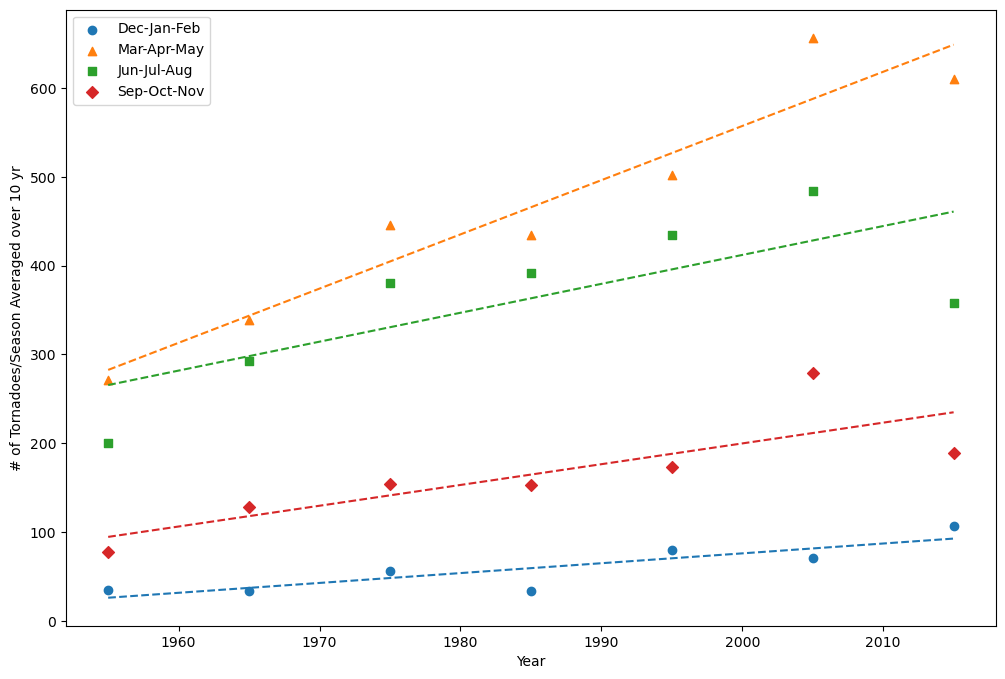

In [21]:
#graphing seasonal counts of tornadoes
seasons = ['Dec-Jan-Feb', 'Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov']
season_marker = ['o', '^', 's', 'D']
i = 0
fig, ax = plt.pyplot.subplots(1,figsize=(12,8))
while i < 4:
    LR_lon = LR()
    LR_lon.fit(year_axis.reshape(-1, 1), N_year_seasons[:,i]/N)
    print(seasons[i] + ' - slope: ', LR_lon.coef_[0])
    lon_pred = LR_lon.predict(year_axis.reshape(-1, 1))
    ax.plot(year_axis, lon_pred, linestyle = '--')
    ax.scatter(year_axis, N_year_seasons[:,i]/N, label = seasons[i], marker = season_marker[i])
    i += 1

ax.legend()
ax.set(xlabel = 'Year', ylabel = '# of Tornadoes/Season Averaged over ' + str(N) + ' yr')
#fig.savefig('seasonal_tornado_counts.pdf')

Dec-Jan-Feb - slope:  0.007895025788101254
Dec-Jan-Feb - intercept:  -104.2961864643903
Mar-Apr-May - slope:  0.006291178751301223
Mar-Apr-May - intercept:  -105.42291547356987
Jun-Jul-Aug - slope:  0.012870971046549539
Jun-Jul-Aug - intercept:  -118.6560920056287
Sep-Oct-Nov - slope:  0.024716349008457025
Sep-Oct-Nov - intercept:  -139.44098335115376


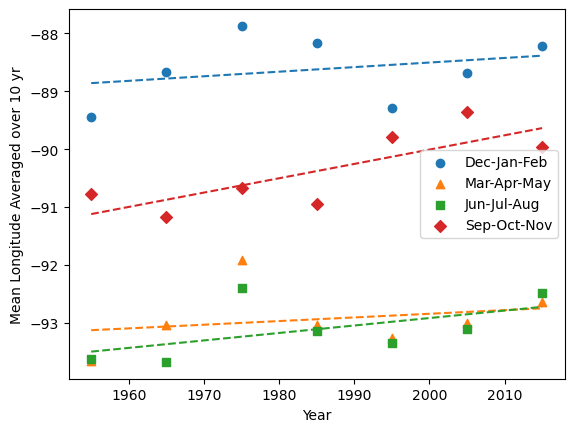

In [22]:
#graphing seasonal longitude of tornadoes
seasons = ['Dec-Jan-Feb', 'Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov']
season_marker = ['o', '^', 's', 'D']
fig, ax = plt.pyplot.subplots(1)
i = 0
while i < 4:
    LR_lon = LR()
    LR_lon.fit(year_axis.reshape(-1, 1), c_m_year_seasons[:,i,0])
    print(seasons[i] + ' - slope: ', LR_lon.coef_[0])
    print(seasons[i] + ' - intercept: ', LR_lon.intercept_)
    lon_pred = LR_lon.predict(year_axis.reshape(-1, 1))
    ax.plot(year_axis, lon_pred, linestyle = '--')
    ax.scatter(year_axis, c_m_year_seasons[:,i,0], label = seasons[i], marker = season_marker[i])
    i += 1

ax.legend()
ax.set(xlabel = 'Year', ylabel = 'Mean Longitude Averaged over ' + str(N) + ' yr')
fig.savefig('seasonal_tornado_longitude.pdf')

Dec-Jan-Feb - slope:  0.002996859388061346
Dec-Jan-Feb - intercept:  27.304276217403636
Mar-Apr-May - slope:  -0.002583429070650695
Mar-Apr-May - intercept:  41.54967889712774
Jun-Jul-Aug - slope:  0.026470114029876517
Jun-Jul-Aug - intercept:  -13.001208276203698
Sep-Oct-Nov - slope:  0.003213380371891185
Sep-Oct-Nov - intercept:  30.524643830720095


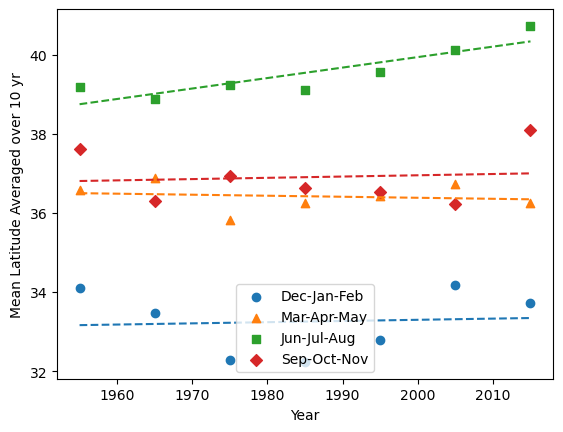

In [23]:
#graphing seasonal latitude of tornadoes
seasons = ['Dec-Jan-Feb', 'Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov']
season_marker = ['o', '^', 's', 'D']
fig, ax = plt.pyplot.subplots(1)
i = 0
while i < 4:
    LR_lat = LR()
    LR_lat.fit(year_axis.reshape(-1, 1), c_m_year_seasons[:,i,1])
    print(seasons[i] + ' - slope: ', LR_lat.coef_[0])
    print(seasons[i] + ' - intercept: ', LR_lat.intercept_)
    lat_pred = LR_lat.predict(year_axis.reshape(-1, 1))
    ax.plot(year_axis, lat_pred, linestyle = '--')
    ax.scatter(year_axis, c_m_year_seasons[:,i,1], label = seasons[i], marker = season_marker[i])
    i += 1

ax.legend()
ax.set(xlabel = 'Year', ylabel = 'Mean Latitude Averaged over ' + str(N) + ' yr')
fig.savefig('seasonal_tornado_latitude.pdf')

Longitude fit - slope:  [0.01571325]
Longitude fit - intercept:  -123.50094938839649
Latitude fit - slope:  [0.0023977]
Latitude fit - intercept:  32.3686025227591


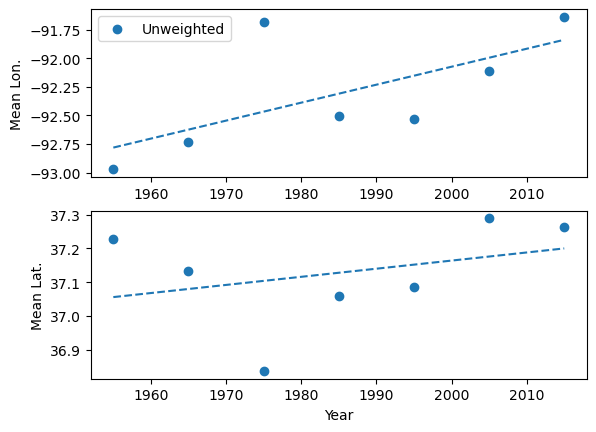

In [24]:
#graphing yearly position of tornadoes
fig, ax = plt.pyplot.subplots(2)
LR_lon = LR()
LR_lon.fit(year_axis.reshape(-1, 1), c_m_year[:,0])
print('Longitude fit - slope: ', LR_lon.coef_)
print('Longitude fit - intercept: ', LR_lon.intercept_)
lon_pred = LR_lon.predict(year_axis.reshape(-1, 1))


ax[0].plot(year_axis, lon_pred, linestyle = '--')
ax[0].scatter(year_axis, c_m_year[:,0], label = 'Unweighted')

ax[0].legend()
ax[0].set(xlabel = '', ylabel = 'Mean Lon.')

LR_lat = LR()
LR_lat.fit(year_axis.reshape(-1, 1), c_m_year[:,1])
print('Latitude fit - slope: ', LR_lat.coef_)
print('Latitude fit - intercept: ', LR_lat.intercept_)
lat_pred = LR_lat.predict(year_axis.reshape(-1, 1))


ax[1].plot(year_axis, lat_pred, linestyle = '--')
ax[1].scatter(year_axis, c_m_year[:,1], label = 'Unweighted')

ax[1].set(xlabel = 'Year', ylabel = 'Mean Lat.')
fig.savefig('yearly_tornado_position.pdf')

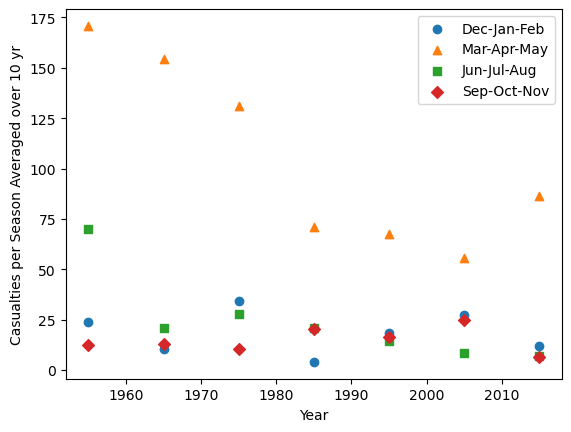

In [25]:
#graphing seasonal counts of tornadoes
seasons = ['Dec-Jan-Feb', 'Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov']
season_marker = ['o', '^', 's', 'D']
i = 0
fig, ax = plt.pyplot.subplots(1)
while i < 4:
    #LR_lon = LR()
    #LR_lon.fit(year_axis.reshape(-1, 1), N_year_seasons[:,i]/N)
    #print(seasons[i] + ' - slope: ', LR_lon.coef_[0])
    #lon_pred = LR_lon.predict(year_axis.reshape(-1, 1))
    #ax.plot(year_axis, lon_pred, linestyle = '--')
    ax.scatter(year_axis, (i_year_seasons[:,i] + d_year_seasons[:,i])/N, label = seasons[i], marker = season_marker[i])
    i += 1

ax.legend()
ax.set(xlabel = 'Year', ylabel = 'Casualties per Season Averaged over ' + str(N) + ' yr')
fig.savefig('tornado_casualties_by_season.pdf')

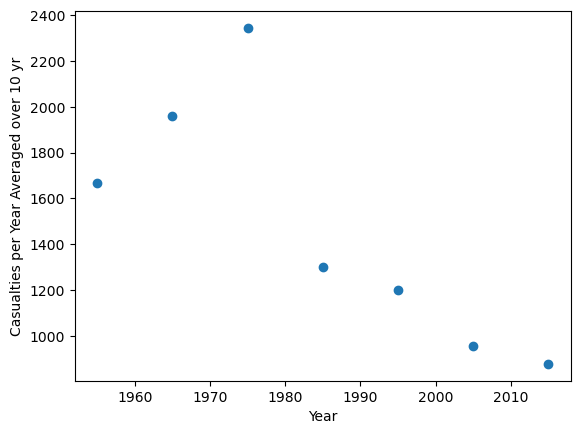

In [26]:
#graphing seasonal counts of tornadoes
seasons = ['Dec-Jan-Feb', 'Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov']
i = 0
fig, ax = plt.pyplot.subplots(1)
ax.scatter(year_axis, (i_year + d_year)/N)

ax.set(xlabel = 'Year', ylabel = 'Casualties per Year Averaged over ' + str(N) + ' yr')
fig.savefig('tornado_casualties_by_year.pdf')